Modelling travel behaviour of reduced-mobility pedestrians in a developing urban area using Machine Learning approaches

In [ ]:
# This cell will prompt you to connect this notebook with your google account.
from google.colab import drive                                                                        
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Docencia/art_JDPJ/en_proceso/reduced_mobility_EOD2017/model/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Importing libraries

In [ ]:
import pandas as pd
import numpy as np
from numpy import interp
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
from tqdm import tqdm
import itertools
import seaborn as sns
from sklearn import *
import sklearn
import pickle
import shap

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RepeatedStratifiedKFold, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, jaccard_similarity_score, f1_score, accuracy_score, balanced_accuracy_score, roc_auc_score, recall_score, roc_curve, auc, roc_curve
from sklearn.utils import resample
from random import randint, uniform

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

#ignore log(0) and divide by 0 warning
np.seterr(divide = 'ignore');
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 


print('Libraries read!')

Libraries read!


### Reading the final dataset

In [ ]:
raw_df_coord = pd.read_csv(base_dir + 'raw_df_coord.csv').iloc[:,1:]
print('Shape of raw_df_coord:', raw_df_coord.shape)
raw_df_coord.head()

Shape of raw_df_coord: (8174, 46)


,travel_time,age,num_cars,num_motorbikes,num_bikes,reason_trip_health,reason_trip_home,reason_trip_leisure,reason_trip_personal_process,reason_trip_shopping,reason_trip_study,reason_trip_work,gender_male,schooling_lower,schooling_middle,occupation_employee,occupation_housewife,occupation_student,work_dedication_full_time,work_dedication_partial_time,laboral_sector_industry,laboral_sector_services,laboral_sector_transport,work_level_assistant,work_level_manager,work_level_operative,workplace_home,workplace_office,disability_yes,household_income_smlv_1_2,household_income_smlv_2_3,household_income_smlv_3_mas,type_home_apartment,type_home_house,type_ownership_house_own,type_ownership_house_rent,stratum_lower,stratum_middle,freq_trip_daily,freq_trip_monthly,freq_trip_weekly,lat_o,lon_o,lat_d,lon_d,main_mode
0,15.0,69.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,6.10947,-75.637497,6.12583,-75.632797,taxi
1,30.0,69.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,6.12583,-75.632797,6.10947,-75.637497,walking
2,30.0,73.0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,6.15640,-75.599098,6.32910,-75.541100,bus
3,30.0,73.0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,6.32910,-75.541100,6.15640,-75.599098,bus
4,5.0,80.0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,6.22877,-75.544998,6.22877,-75.544998,walking


In [ ]:
raw_df_coord.describe(include='all')

,travel_time,age,num_cars,num_motorbikes,num_bikes,reason_trip_health,reason_trip_home,reason_trip_leisure,reason_trip_personal_process,reason_trip_shopping,reason_trip_study,reason_trip_work,gender_male,schooling_lower,schooling_middle,occupation_employee,occupation_housewife,occupation_student,work_dedication_full_time,work_dedication_partial_time,laboral_sector_industry,laboral_sector_services,laboral_sector_transport,work_level_assistant,work_level_manager,work_level_operative,workplace_home,workplace_office,disability_yes,household_income_smlv_1_2,household_income_smlv_2_3,household_income_smlv_3_mas,type_home_apartment,type_home_house,type_ownership_house_own,type_ownership_house_rent,stratum_lower,stratum_middle,freq_trip_daily,freq_trip_monthly,freq_trip_weekly,lat_o,lon_o,lat_d,lon_d,main_mode
count,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,walking
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3877
mean,29.574505,67.940666,0.243333,0.146195,0.054563,0.080744,0.468804,0.076095,0.092611,0.083435,0.011378,0.085026,0.530707,0.816247,0.080132,0.197822,0.269635,0.024223,0.140323,0.080010,0.053707,0.146929,0.018596,0.028016,0.056888,0.103621,0.045388,0.080866,0.205652,0.353927,0.163567,0.133472,0.315268,0.679839,0.743700,0.217397,0.469293,0.431735,0.459628,0.191583,0.311965,10.909751,-75.567583,10.909734,-75.567595,NaN
std,22.479465,13.261104,0.524105,0.422987,0.298384,0.272458,0.499056,0.265166,0.289904,0.276556,0.106064,0.278937,0.499087,0.387307,0.271514,0.398382,0.443798,0.153751,0.347343,0.271325,0.225452,0.354057,0.135100,0.165028,0.231642,0.304787,0.208166,0.272646,0.404202,0.478216,0.369905,0.340105,0.464651,0.466567,0.436616,0.412500,0.499087,0.495348,0.498398,0.393571,0.463324,171.439590,0.060687,171.439591,0.060675,NaN
min,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.946810,-75.794502,5.946810,-75.794502,NaN
25%,10.000000,66.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.205090,-75.595703,6.205090,-75.595703,NaN
50%,28.500000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.252260,-7

In [ ]:
raw_df_coord['main_mode'].value_counts()

walking                3877
bus                    1390
sitva                   801
taxi                    759
car_driver              635
car_passenger           349
other                   149
motorbike_driver        119
bike                     66
motorbike_passenger      29
Name: main_mode, dtype: int64

In [ ]:
# Replacing main modes
raw_df_coord['main_mode'] = raw_df_coord['main_mode'].replace(['walking', 'bus', 'taxi', 'sitva', 'car_driver', 'car_passenger', 'other', 'motorbike_driver', 'bike', 'motorbike_passenger'],
                                                  ['walking', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other'])



In [ ]:
raw_df_coord['main_mode'].value_counts()

other      4297
walking    3877
Name: main_mode, dtype: int64

In [ ]:
raw_df_coord['main_mode'] = raw_df_coord['main_mode'].astype('category')
raw_df_coord['main_mode'] = raw_df_coord['main_mode'].cat.codes

In [ ]:
raw_df_coord.main_mode.value_counts()

0    4297
1    3877
Name: main_mode, dtype: int64

# 1. Modelling

In [ ]:
# Splitting data in X and Y
y = raw_df_coord['main_mode']
X = raw_df_coord.drop('main_mode',axis = 1)

#### Correlation between variables

It is common that some features can be correlated against each other, so it is important to know which variables present this kind of correlations. However, the sklearn library permits perform models without need of discard these correlated features.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
        44.5]), <a list of 45 Text major ticklabel objects>)

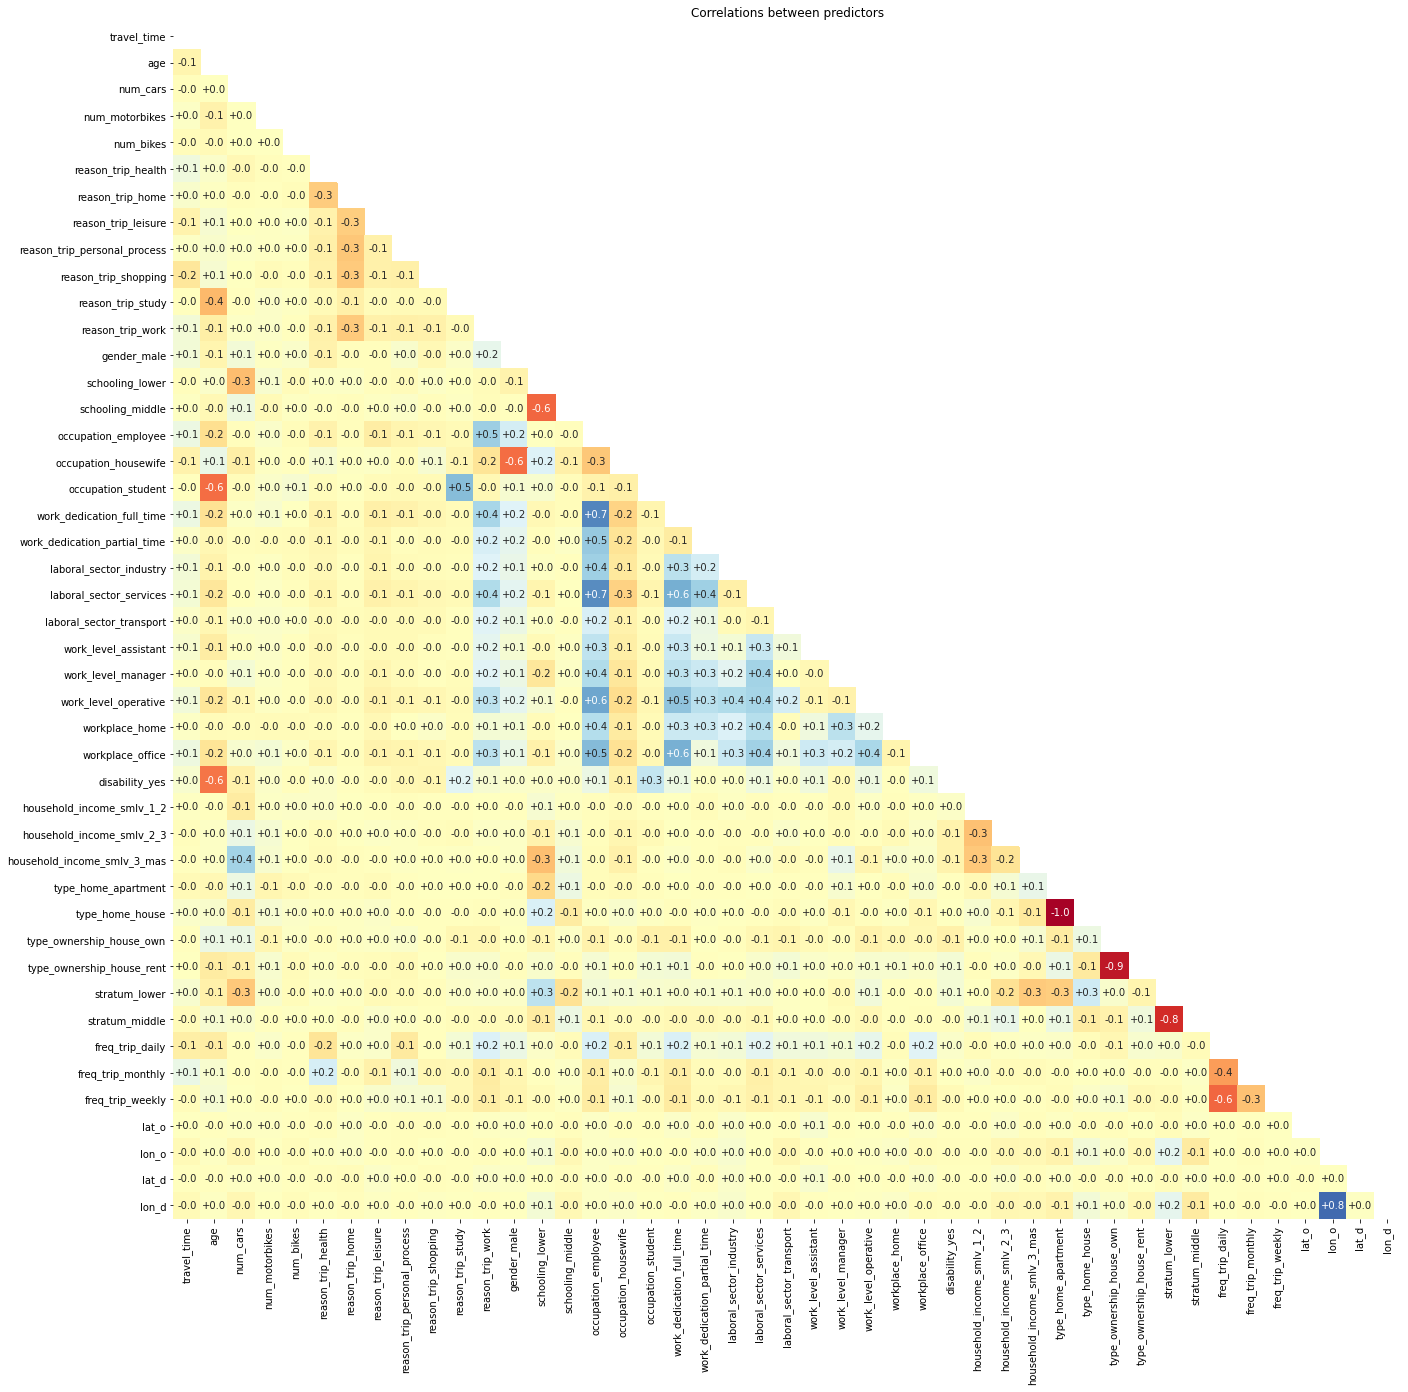

In [ ]:
plt.figure(figsize=(22,22))
Correlation = X.corr()

mask = np.zeros(Correlation.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

sns.heatmap(Correlation, cmap='RdYlBu', annot=True, fmt="+.1f", vmin = -1, vmax = 1, center = 0, cbar=False, mask=mask)

plt.title("Correlations between predictors")
plt.yticks(rotation=0)

As we can see, there are several strong correlations (>= |0.6|) between the following features:
- schooling_middle and schooling_lower
- occupation_housewife and gender_male
- occupation_student and age
- work_dedication_full_time and occupation_employee
- laboral_sector_services and occupation_employee
- laboral_sector_services and work_dedication_full_time
- work_level_operative and occupation_employee
- workplace_office and work_dedication_full_time
- disability_yes and age
- type_home_house and type_home_apartment
- type_ownership_house_rent and type_ownership_house_own
- stratum_lower and stratum_middle
- freq_trip_weekly and freq_trip_daily
- lon_o and lon_d


For this reason, we remove the following features:
- schooling_middle
- occupation_housewife
- occupation_student
- occupation_employee
- work_dedication_full_time
- type_home_apartment
- type_ownership_house_rent
- stratum_middle
- type_home_apartment
- freq_trip_weekly
- lon_o


In [ ]:
X = X.drop([ 'schooling_middle', 'occupation_housewife', 'occupation_student', 'occupation_employee', 'work_dedication_full_time',
            'type_home_apartment', 'type_ownership_house_rent', 'stratum_middle', 'type_home_apartment', 'freq_trip_weekly', 'lon_o', 
            ], axis = 1)
X.columns

Index(['travel_time', 'age', 'num_cars', 'num_motorbikes', 'num_bikes',
       'reason_trip_health', 'reason_trip_home', 'reason_trip_leisure',
       'reason_trip_personal_process', 'reason_trip_shopping',
       'reason_trip_study', 'reason_trip_work', 'gender_male',
       'schooling_lower', 'work_dedication_partial_time',
       'laboral_sector_industry', 'laboral_sector_services',
       'laboral_sector_transport', 'work_level_assistant',
       'work_level_manager', 'work_level_operative', 'workplace_home',
       'workplace_office', 'disability_yes', 'household_income_smlv_1_2',
       'household_income_smlv_2_3', 'household_income_smlv_3_mas',
       'type_home_house', 'type_ownership_house_own', 'stratum_lower',
       'freq_trip_daily', 'freq_trip_monthly', 'lat_o', 'lat_d', 'lon_d'],
      dtype='object')

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5]), <a list of 35 Text major ticklabel objects>)

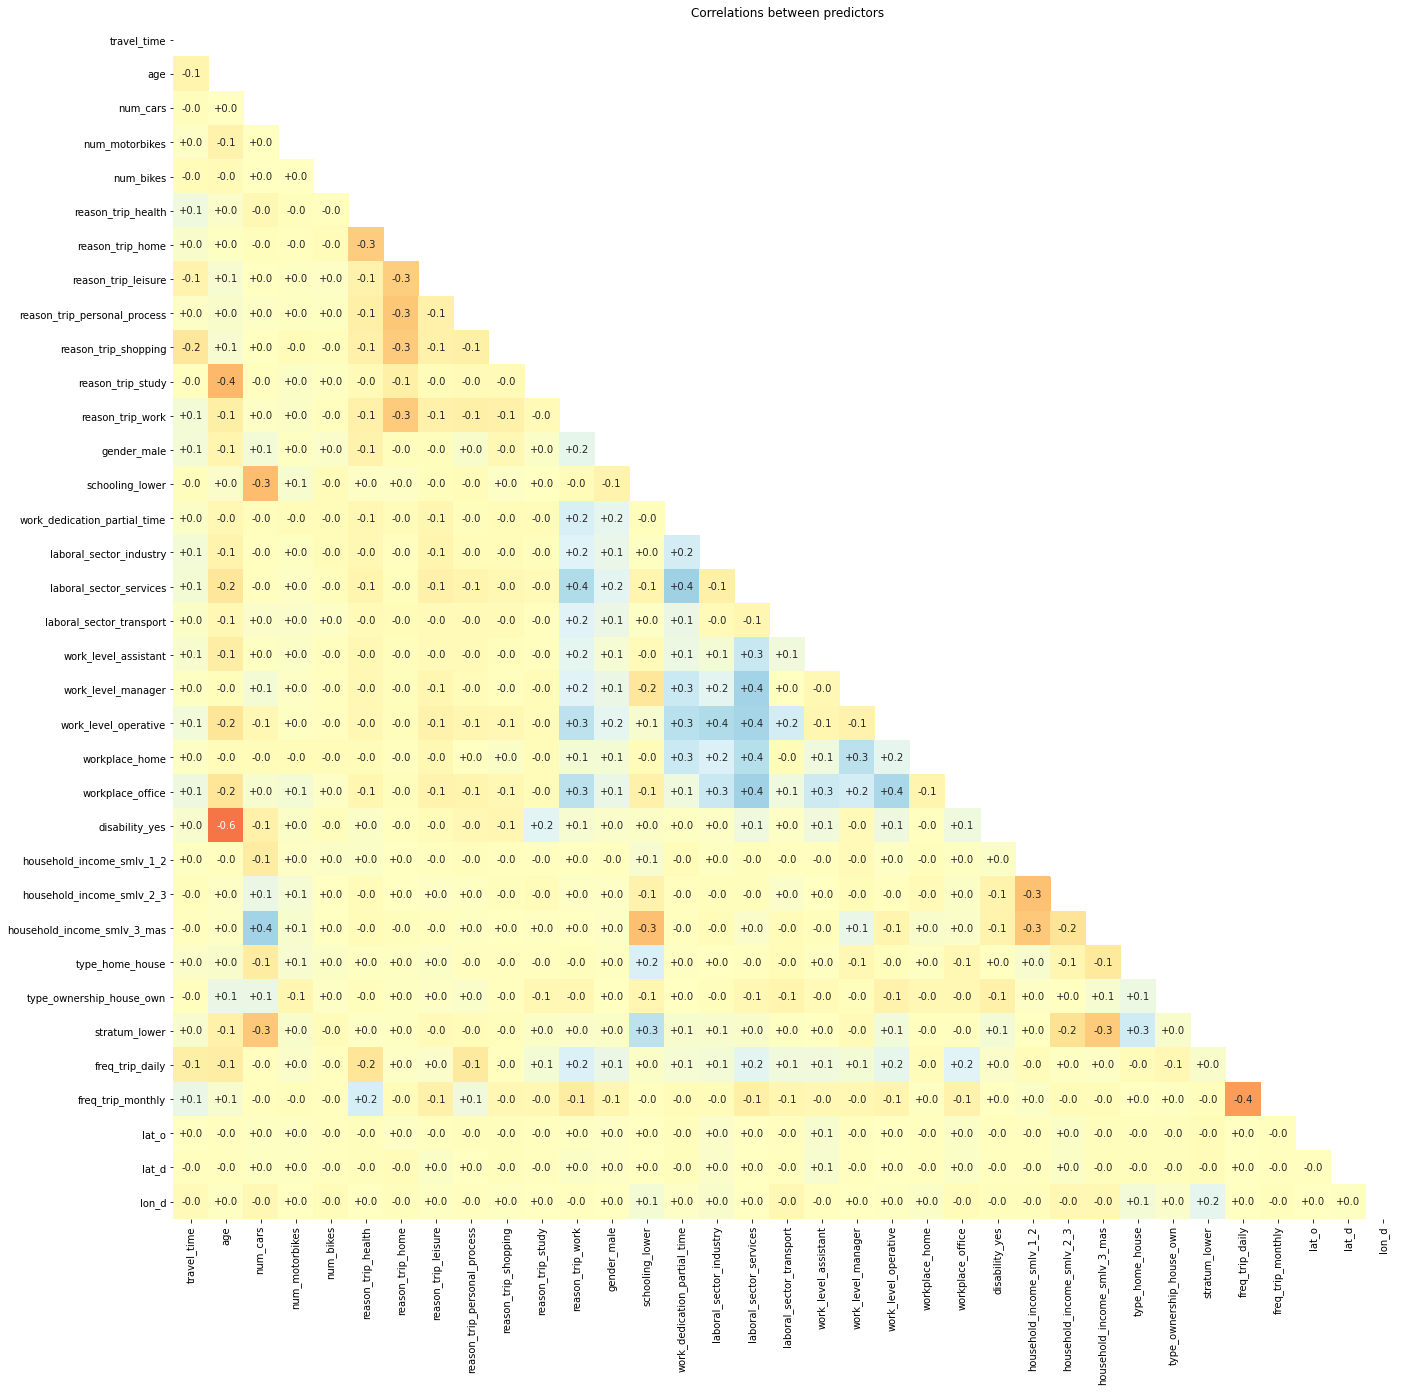

In [ ]:
plt.figure(figsize=(22,22))
Correlation = X.corr()

mask = np.zeros(Correlation.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

sns.heatmap(Correlation, cmap='RdYlBu', annot=True, fmt="+.1f", vmin = -1, vmax = 1, center = 0, cbar=False, mask=mask)

plt.title("Correlations between predictors")
plt.yticks(rotation=0)

In [ ]:
y.value_counts()

0    4297
1    3877
Name: main_mode, dtype: int64

In [ ]:
X_columns_final = X.columns
X_columns_final

Index(['travel_time', 'age', 'num_cars', 'num_motorbikes', 'num_bikes',
       'reason_trip_health', 'reason_trip_home', 'reason_trip_leisure',
       'reason_trip_personal_process', 'reason_trip_shopping',
       'reason_trip_study', 'reason_trip_work', 'gender_male',
       'schooling_lower', 'work_dedication_partial_time',
       'laboral_sector_industry', 'laboral_sector_services',
       'laboral_sector_transport', 'work_level_assistant',
       'work_level_manager', 'work_level_operative', 'workplace_home',
       'workplace_office', 'disability_yes', 'household_income_smlv_1_2',
       'household_income_smlv_2_3', 'household_income_smlv_3_mas',
       'type_home_house', 'type_ownership_house_own', 'stratum_lower',
       'freq_trip_daily', 'freq_trip_monthly', 'lat_o', 'lat_d', 'lon_d'],
      dtype='object')

In [ ]:
# Splitting data in training and test data
seed = 88
test_size = 0.25
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size,random_state=seed, stratify=y)
print('Shape of X_train: ', X_train.shape, ' and y_train: ', y_train.shape)
print('Shape of X_test: ', X_test.shape, ' and y_test: ', y_test.shape)

Shape of X_train:  (6130, 35)  and y_train:  (6130,)
Shape of X_test:  (2044, 35)  and y_test:  (2044,)


In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # apply same transformation to test data

# Analysing class weights

In [ ]:
neg, pos = np.bincount(raw_df_coord['main_mode'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 8174
    Positive: 3877 (47.43% of total)



In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


Weight for class 0: 0.95
Weight for class 1: 1.05




```
# This is formatted as code
```

# 2. Testing models

 33%|███▎      | 2/6 [00:01<00:03,  1.12it/s]

LR: ROC_AUC_train_score: 0.79, ROC_AUC_test_score: 0.78, f1_test: 0.77, recall_test: 0.77
Ridge: ROC_AUC_train_score: 0.78, ROC_AUC_test_score: 0.78, f1_test: 0.77, recall_test: 0.77


 50%|█████     | 3/6 [00:22<00:20,  6.98s/it]

SVM: ROC_AUC_train_score: 0.82, ROC_AUC_test_score: 0.78, f1_test: 0.77, recall_test: 0.78


 67%|██████▋   | 4/6 [00:27<00:13,  6.52s/it]

RF: ROC_AUC_train_score: 0.84, ROC_AUC_test_score: 0.81, f1_test: 0.79, recall_test: 0.81


 83%|████████▎ | 5/6 [00:34<00:06,  6.40s/it]

XGB: ROC_AUC_train_score: 0.83, ROC_AUC_test_score: 0.81, f1_test: 0.80, recall_test: 0.82


100%|██████████| 6/6 [00:50<00:00,  8.34s/it]

ANN: ROC_AUC_train_score: 0.79, ROC_AUC_test_score: 0.78, f1_test: 0.76, recall_test: 0.79


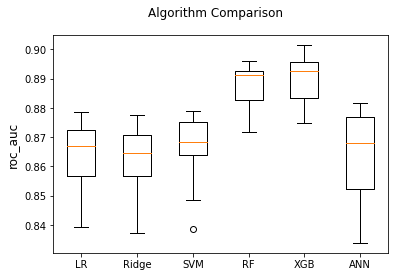

In [ ]:
# Comparison of all better tunned classifiers
models = []

models.append(('LR', LogisticRegression( )) )
models.append(('Ridge', RidgeClassifier( )) )
models.append(('SVM', SVC( )) )
models.append(('RF', RandomForestClassifier(min_samples_leaf=15)) )
models.append(('XGB', XGBClassifier()) )
models.append(('ANN', MLPClassifier(early_stopping=True, max_iter=1000)) )


#Evaluating each model
results = []
names = []

for name, model in tqdm(models):
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring="roc_auc")
    results.append(cv_results)
    names.append(name)
    
    
    model_result = model.fit(X_train,y_train)
    ypred_train = model_result.predict(X_train)
    ypred_test = model_result.predict(X_test)
    
    
    fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, ypred_train)
    roc_auc_train = auc(fpr_train, tpr_train)
    
    
    fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, ypred_test)
    roc_auc_test = auc(fpr_test, tpr_test)
    
    
    
    
    msg = "%s: ROC_AUC_train_score: %.2f, ROC_AUC_test_score: %.2f, f1_test: %.2f, recall_test: %.2f" % (
        name, roc_auc_train, roc_auc_test, f1_score(ypred_test, y_test), recall_score(ypred_test, y_test)
        )

    print(msg)

    
# Comparing all the models
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot()
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylabel('roc_auc', fontsize=12)
plt.show()

In [ ]:
# Defining plot_confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(4, 3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.1 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
def plot_learning_curve_auc(estimator, X, y, cv=None, ylim=None):
    
    plt.figure()
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.ylabel('ROC_AUC', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14) 
    
    train_sizes, train_scores, validation_scores = model_selection.learning_curve(
        estimator, X, y, cv=5, train_sizes=np.linspace(.1, 1.0, 50), scoring = 'roc_auc')
    
    train_scores_mean = np.mean(train_scores, axis = 1)
    validation_scores_mean = np.mean(validation_scores, axis = 1)
    
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)


    plt.plot(train_sizes, train_scores_mean, color="r", label = 'Training data')
    plt.plot(train_sizes, validation_scores_mean, color="g", label = 'Validation data')
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    

    plt.legend(loc="best")
    plt.ylim()
    
    return plt


# 3. Verifying the Logistic Regression Model

In [ ]:
LR_params = LogisticRegression()
LR = LR_params.fit(X_train,y_train)
LR

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Now we can predict using our test set:

RESULTS FOR LOGISTIC REGRESSION:
-------------------
yhat:  [1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 1]
yhat_prob:  [[0.13 0.87]
 [0.87 0.13]
 [0.8  0.2 ]
 ...
 [0.93 0.07]
 [0.11 0.89]
 [0.07 0.93]]
The mean accuracy of training data is:  0.79
The mean accuracy of test data is:  0.78
Jaccard_index test:  0.78
f1_score_test:  [0.79 0.77]
f1_score_test_macro:  0.78
roc_auc_test:  0.78
-----------------
cnf_matrix:
  [[856 219]
 [228 741]]


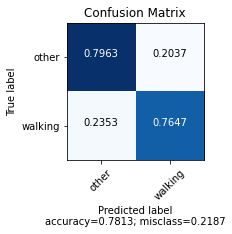

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [ ]:
print('RESULTS FOR LOGISTIC REGRESSION:')
print('-------------------')

yhat = LR.predict(X_test)
print('yhat: ', yhat[0:20])

yhat_prob = LR.predict_proba(X_test)
print('yhat_prob: ', yhat_prob)
      
print('The mean accuracy of training data is: ', round(LR.score(X_train,y_train), 2))
print('The mean accuracy of test data is: ', round(LR.score(X_test,y_test), 2))

print('Jaccard_index test: ', round(jaccard_similarity_score(y_test, yhat), 2))

print('f1_score_test: ', f1_score(y_test, yhat, average=None))
print('f1_score_test_macro: ', round(f1_score(y_test, yhat, average='macro'),2))

fpr, tpr, thresholds = metrics.roc_curve(y_test, yhat)
roc_auc = auc(fpr, tpr)
print('roc_auc_test: ', round(roc_auc,2))

print('-----------------')

cnf_matrix = confusion_matrix(y_test, yhat)
print('cnf_matrix:\n ', cnf_matrix)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, 
                      normalize    = True,
                      target_names = ['other','walking'],
                      title        = "Confusion Matrix")

plt.figure(figsize=(20, 20))


# 4. Verifying the Random Forest Model

In [ ]:
RF_params = RandomForestClassifier(min_samples_leaf=15)
RF = RF_params.fit(X_train,y_train)
RF

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Now we can predict using our test set:

RESULTS FOR RANDOM FOREST:
-------------------
yhat:  [1 1 1 0 1 0 1 0 1 0 0 0 0 1 0 1 1 0 0 1]
yhat_prob:  [[0.39 0.61]
 [0.29 0.71]
 [0.28 0.72]
 ...
 [0.47 0.53]
 [0.35 0.65]
 [0.16 0.84]]
The mean accuracy of training data is:  0.84
The mean accuracy of test data is:  0.82
Jaccard_index test:  0.82
f1_score_test:  [0.83 0.8 ]
f1_score_test_macro:  0.82
roc_auc_test:  0.82
-----------------
cnf_matrix:
  [[921 154]
 [217 752]]


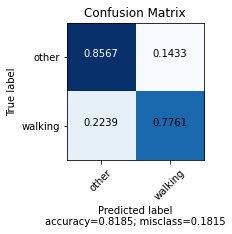

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [ ]:
print('RESULTS FOR RANDOM FOREST:')
print('-------------------')

yhat = RF.predict(X_test)
print('yhat: ', yhat[0:20])

yhat_prob = RF.predict_proba(X_test)
print('yhat_prob: ', yhat_prob)
      
print('The mean accuracy of training data is: ', round(RF.score(X_train,y_train), 2))
print('The mean accuracy of test data is: ', round(RF.score(X_test,y_test), 2))

print('Jaccard_index test: ', round(jaccard_similarity_score(y_test, yhat), 2))

print('f1_score_test: ', f1_score(y_test, yhat, average=None))
print('f1_score_test_macro: ', round(f1_score(y_test, yhat, average='macro'),2))

fpr, tpr, thresholds = metrics.roc_curve(y_test, yhat)
roc_auc = auc(fpr, tpr)
print('roc_auc_test: ', round(roc_auc,2))

print('-----------------')

cnf_matrix = confusion_matrix(y_test, yhat)
print('cnf_matrix:\n ', cnf_matrix)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, 
                      normalize    = True,
                      target_names = ['other','walking'],
                      title        = "Confusion Matrix")

plt.figure(figsize=(20, 20))


# 5. Verifying the Gradient Boosting Model

In [ ]:
XGB_params = XGBClassifier()
XGB = XGB_params.fit(X_train,y_train)
XGB

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Now we can predict using our test set:

RESULTS FOR GRADIENT BOOSTING:
-------------------
yhat:  [1 1 1 0 1 0 1 0 1 0 0 0 0 1 0 1 1 0 0 1]
yhat_prob:  [[0.32 0.68]
 [0.24 0.76]
 [0.11 0.89]
 ...
 [0.52 0.48]
 [0.3  0.7 ]
 [0.08 0.92]]
The mean accuracy of training data is:  0.82
The mean accuracy of test data is:  0.81
Jaccard_index test:  0.81
f1_score_test:  [0.82 0.79]
f1_score_test_macro:  0.81
roc_auc_test:  0.81
-----------------
cnf_matrix:
  [[902 173]
 [221 748]]


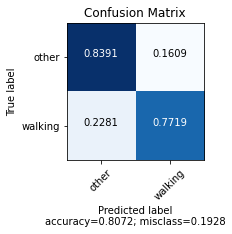

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [ ]:
print('RESULTS FOR GRADIENT BOOSTING:')
print('-------------------')

yhat = XGB.predict(X_test)
print('yhat: ', yhat[0:20])

yhat_prob = XGB.predict_proba(X_test)
print('yhat_prob: ', yhat_prob)
      
print('The mean accuracy of training data is: ', round(XGB.score(X_train,y_train), 2))
print('The mean accuracy of test data is: ', round(XGB.score(X_test,y_test), 2))

print('Jaccard_index test: ', round(jaccard_similarity_score(y_test, yhat), 2))

print('f1_score_test: ', f1_score(y_test, yhat, average=None))
print('f1_score_test_macro: ', round(f1_score(y_test, yhat, average='macro'),2))

fpr, tpr, thresholds = metrics.roc_curve(y_test, yhat)
roc_auc = auc(fpr, tpr)
print('roc_auc_test: ', round(roc_auc,2))

print('-----------------')

cnf_matrix = confusion_matrix(y_test, yhat)
print('cnf_matrix:\n ', cnf_matrix)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, 
                      normalize    = True,
                      target_names = ['other','walking'],
                      title        = "Confusion Matrix")

plt.figure(figsize=(20, 20))


# 6. Hyperparameter tuning

## 6.1. Logistic Regression Classifier

In [ ]:
# define models and parameters
model = LogisticRegression()

model_params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear', 'saga', 'sag', 'lbfgs', 'newton-cg'],
    'class_weight': [class_weight, 'balanced']
     }

# Defining the grid search, using the cross-validation method

grid_search = RandomizedSearchCV(estimator=model, param_distributions=model_params, n_iter=300, n_jobs=-1, cv=10, scoring='roc_auc', verbose=10)
grid_result = grid_search.fit(X_train, y_train)

best_estimator = grid_result.best_estimator_

ypred_train = best_estimator.predict(X_train)
ypred_test = best_estimator.predict(X_test)
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, ypred_train)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, ypred_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Summarizing results
print("Best: %.2f, ROC_AUC_train_score: %.2f, ROC_AUC_test_score: %.2f. Using %s" % (grid_result.best_score_, roc_auc_train, roc_auc_test, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']



for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0602s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1889s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 356 tasks      | elapsed:   15.2s
[Parallel(n_jo

Best: 0.86, ROC_AUC_train_score: 0.79, ROC_AUC_test_score: 0.78. Using {'solver': 'liblinear', 'penalty': 'l1', 'class_weight': {0: 0.95112869443798, 1: 1.0541655919525408}, 'C': 0.615848211066026}
0.862589 (0.018489) with: {'solver': 'liblinear', 'penalty': 'l2', 'class_weight': {0: 0.95112869443798, 1: 1.0541655919525408}, 'C': 545.5594781168514}
0.862595 (0.018491) with: {'solver': 'sag', 'penalty': 'l2', 'class_weight': 'balanced', 'C': 206.913808111479}
0.862582 (0.018485) with: {'solver': 'lbfgs', 'penalty': 'none', 'class_weight': {0: 0.95112869443798, 1: 1.0541655919525408}, 'C': 206.913808111479}
0.862582 (0.018485) with: {'solver': 'lbfgs', 'penalty': 'none', 'class_weight': {0: 0.95112869443798, 1: 1.0541655919525408}, 'C': 11.288378916846883}
nan (nan) with: {'solver': 'lbfgs', 'penalty': 'elasticnet', 'class_weight': {0: 0.95112869443798, 1: 1.0541655919525408}, 'C': 0.0018329807108324356}
0.862591 (0.018487) with: {'solver': 'sag', 'penalty': 'l2', 'class_weight': {0: 0.9

In [ ]:
LR_params = LogisticRegression(penalty='l1', C=0.6158, solver='liblinear', class_weight=class_weight, )
LR = LR_params.fit(X_train,y_train)
LR

LogisticRegression(C=0.6158,
                   class_weight={0: 0.95112869443798, 1: 1.0541655919525408},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='l1', random_state=None, solver='liblinear',
                   tol=0.0001, verbose=0, warm_start=False)

Now we can predict using our test set:

RESULTS FOR LOGISTIC REGRESSION:
-------------------
yhat:  [1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 1]
yhat_prob:  [[0.11 0.89]
 [0.85 0.15]
 [0.79 0.21]
 ...
 [0.93 0.07]
 [0.1  0.9 ]
 [0.06 0.94]]
The mean accuracy of training data is:  0.78
The mean accuracy of test data is:  0.77
Jaccard_index test:  0.77
f1_score_test:  [0.78 0.77]
f1_score_test_macro:  0.77
roc_auc_test:  0.77
-----------------
cnf_matrix:
  [[823 252]
 [210 759]]


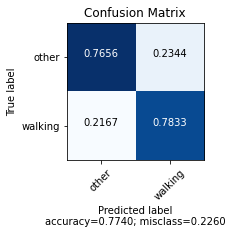

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [ ]:
print('RESULTS FOR LOGISTIC REGRESSION:')
print('-------------------')

yhat = LR.predict(X_test)
print('yhat: ', yhat[0:20])

yhat_prob = LR.predict_proba(X_test)
print('yhat_prob: ', yhat_prob)
      
print('The mean accuracy of training data is: ', round(LR.score(X_train,y_train), 2))
print('The mean accuracy of test data is: ', round(LR.score(X_test,y_test), 2))

print('Jaccard_index test: ', round(jaccard_similarity_score(y_test, yhat), 2))

print('f1_score_test: ', f1_score(y_test, yhat, average=None))
print('f1_score_test_macro: ', round(f1_score(y_test, yhat, average='macro'),2))

fpr, tpr, thresholds = metrics.roc_curve(y_test, yhat)
roc_auc = auc(fpr, tpr)
print('roc_auc_test: ', round(roc_auc,2))

print('-----------------')

cnf_matrix = confusion_matrix(y_test, yhat)
print('cnf_matrix:\n ', cnf_matrix)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, 
                      normalize    = True,
                      target_names = ['other','walking'],
                      title        = "Confusion Matrix")

plt.figure(figsize=(20, 20))


Feature: 0, Score: -6.90490
Feature: 1, Score: 0.87601
Feature: 2, Score: -3.72868
Feature: 3, Score: -0.28547
Feature: 4, Score: 0.00000
Feature: 5, Score: -1.30350
Feature: 6, Score: -0.25251
Feature: 7, Score: 0.98973
Feature: 8, Score: -0.78559
Feature: 9, Score: 0.27170
Feature: 10, Score: -0.58498
Feature: 11, Score: -0.80064
Feature: 12, Score: 0.05381
Feature: 13, Score: 0.26117
Feature: 14, Score: 0.59482
Feature: 15, Score: -0.54411
Feature: 16, Score: -0.94749
Feature: 17, Score: -2.43812
Feature: 18, Score: -0.07547
Feature: 19, Score: -0.32901
Feature: 20, Score: 0.02446
Feature: 21, Score: -0.04701
Feature: 22, Score: -0.01389
Feature: 23, Score: 0.09499
Feature: 24, Score: -0.16550
Feature: 25, Score: -0.44521
Feature: 26, Score: -0.85954
Feature: 27, Score: -0.09075
Feature: 28, Score: -0.00308
Feature: 29, Score: -0.09292
Feature: 30, Score: 0.94700
Feature: 31, Score: -0.76838
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.92995


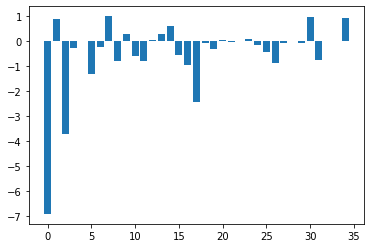

Index(['travel_time', 'age', 'num_cars', 'num_motorbikes', 'num_bikes',
       'reason_trip_health', 'reason_trip_home', 'reason_trip_leisure',
       'reason_trip_personal_process', 'reason_trip_shopping',
       'reason_trip_study', 'reason_trip_work', 'gender_male',
       'schooling_lower', 'work_dedication_partial_time',
       'laboral_sector_industry', 'laboral_sector_services',
       'laboral_sector_transport', 'work_level_assistant',
       'work_level_manager', 'work_level_operative', 'workplace_home',
       'workplace_office', 'disability_yes', 'household_income_smlv_1_2',
       'household_income_smlv_2_3', 'household_income_smlv_3_mas',
       'type_home_house', 'type_ownership_house_own', 'stratum_lower',
       'freq_trip_daily', 'freq_trip_monthly', 'lat_o', 'lat_d', 'lon_d'],
      dtype='object')


In [ ]:
# Feature Importance

importance = LR_params.coef_[0]

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
print(X.columns)

## 6.2. Random Forest Model

In [ ]:
# define models and parameters
model = RandomForestClassifier()

model_params = {
    'n_estimators': list(range(2, 101)),
    'min_samples_split': list(range(2, 11)),
    'min_samples_leaf': list(range(6, 20))
     }

# Defining the grid search, using the cross-validation method

grid_search = RandomizedSearchCV(estimator=model, param_distributions=model_params, n_iter=300, n_jobs=-1, cv=10, scoring='roc_auc', verbose=10)
grid_result = grid_search.fit(X_train, y_train)

best_estimator = grid_result.best_estimator_

ypred_train = best_estimator.predict(X_train)
ypred_test = best_estimator.predict(X_test)

fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, ypred_train)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, ypred_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Summarizing results
print("Best: %.2f, ROC_AUC_train_score: %.2f, ROC_AUC_test_score: %.2f. Using %s" % (grid_result.best_score_, roc_auc_train, roc_auc_test, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']



for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

Best: 0.90, ROC_AUC_train_score: 0.88, ROC_AUC_test_score: 0.83. Using {'n_estimators': 82, 'min_samples_split': 5, 'min_samples_leaf': 6}
0.886749 (0.007477) with: {'n_estimators': 98, 'min_samples_split': 10, 'min_samples_leaf': 17}
0.887925 (0.007221) with: {'n_estimators': 48, 'min_samples_split': 2, 'min_samples_leaf': 14}
0.888454 (0.008655) with: {'n_estimators': 20, 'min_samples_split': 3, 'min_samples_leaf': 11}
0.895432 (0.007215) with: {'n_estimators': 68, 'min_samples_split': 8, 'min_samples_leaf': 9}
0.895432 (0.007588) with: {'n_estimators': 21, 'min_samples_split': 8, 'min_samples_leaf': 8}
0.886371 (0.008312) with: {'n_estimators': 89, 'min_samples_split': 9, 'min_samples_leaf': 17}
0.898579 (0.007661) with: {'n_estimators': 22, 'min_samples_split': 10, 'min_samples_leaf': 6}
0.884017 (0.006868) with: {'n_estimators': 54, 'min_samples_split': 9, 'min_samples_leaf': 19}
0.893662 (0.007171) with: {'n_estimators': 75, 'min_samples_split': 2, 'min_samples_leaf': 10}
0.89072

In [ ]:
RF_params = RandomForestClassifier(n_estimators=82, min_samples_leaf=6, min_samples_split=5)
RF = RF_params.fit(X_train,y_train)
RF

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=82,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Now we can predict using our test set:

RESULTS FOR RANDOM FOREST:
-------------------
yhat:  [1 1 1 0 1 0 1 0 1 0 0 0 0 1 0 1 1 0 0 1]
yhat_prob:  [[0.35 0.65]
 [0.24 0.76]
 [0.28 0.72]
 ...
 [0.48 0.52]
 [0.29 0.71]
 [0.07 0.93]]
The mean accuracy of training data is:  0.88
The mean accuracy of test data is:  0.83
Jaccard_index test:  0.83
f1_score_test:  [0.84 0.81]
f1_score_test_macro:  0.83
roc_auc_test:  0.83
-----------------
cnf_matrix:
  [[929 146]
 [203 766]]


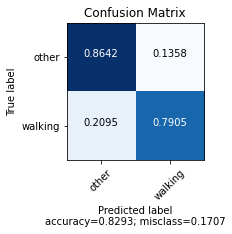

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [ ]:
print('RESULTS FOR RANDOM FOREST:')
print('-------------------')

yhat = RF.predict(X_test)
print('yhat: ', yhat[0:20])

yhat_prob = RF.predict_proba(X_test)
print('yhat_prob: ', yhat_prob)
      
print('The mean accuracy of training data is: ', round(RF.score(X_train,y_train), 2))
print('The mean accuracy of test data is: ', round(RF.score(X_test,y_test), 2))

print('Jaccard_index test: ', round(jaccard_similarity_score(y_test, yhat), 2))

print('f1_score_test: ', f1_score(y_test, yhat, average=None))
print('f1_score_test_macro: ', round(f1_score(y_test, yhat, average='macro'),2))

fpr, tpr, thresholds = metrics.roc_curve(y_test, yhat)
roc_auc = auc(fpr, tpr)
print('roc_auc_test: ', round(roc_auc,2))

print('-----------------')

cnf_matrix = confusion_matrix(y_test, yhat)
print('cnf_matrix:\n ', cnf_matrix)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, 
                      normalize    = True,
                      target_names = ['other','walking'],
                      title        = "Confusion Matrix")

plt.figure(figsize=(20, 20))


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

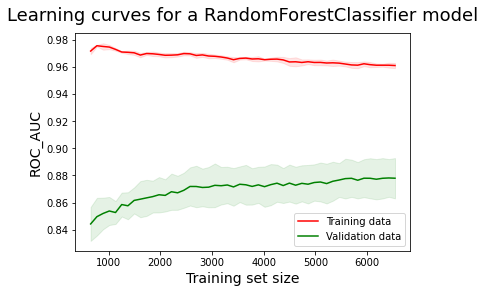

In [ ]:
cv = model_selection.ShuffleSplit(n_splits = 50, test_size = 0.30, random_state = 42)
estimator = RF_params
plot_learning_curve_auc(estimator, X, y, ylim=(), cv=cv)

Feature: 0, Score: 0.34614
Feature: 1, Score: 0.04384
Feature: 2, Score: 0.03495
Feature: 3, Score: 0.00418
Feature: 4, Score: 0.00527
Feature: 5, Score: 0.02346
Feature: 6, Score: 0.00879
Feature: 7, Score: 0.02755
Feature: 8, Score: 0.00857
Feature: 9, Score: 0.01072
Feature: 10, Score: 0.00030
Feature: 11, Score: 0.01195
Feature: 12, Score: 0.01073
Feature: 13, Score: 0.01191
Feature: 14, Score: 0.00253
Feature: 15, Score: 0.00225
Feature: 16, Score: 0.01309
Feature: 17, Score: 0.00697
Feature: 18, Score: 0.00174
Feature: 19, Score: 0.00477
Feature: 20, Score: 0.00565
Feature: 21, Score: 0.00255
Feature: 22, Score: 0.01085
Feature: 23, Score: 0.00489
Feature: 24, Score: 0.00942
Feature: 25, Score: 0.00602
Feature: 26, Score: 0.01618
Feature: 27, Score: 0.00819
Feature: 28, Score: 0.00712
Feature: 29, Score: 0.00918
Feature: 30, Score: 0.06114
Feature: 31, Score: 0.04958
Feature: 32, Score: 0.08339
Feature: 33, Score: 0.08405
Feature: 34, Score: 0.06206


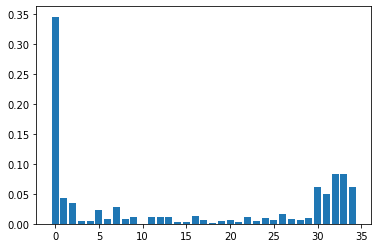

Index(['travel_time', 'age', 'num_cars', 'num_motorbikes', 'num_bikes',
       'reason_trip_health', 'reason_trip_home', 'reason_trip_leisure',
       'reason_trip_personal_process', 'reason_trip_shopping',
       'reason_trip_study', 'reason_trip_work', 'gender_male',
       'schooling_lower', 'work_dedication_partial_time',
       'laboral_sector_industry', 'laboral_sector_services',
       'laboral_sector_transport', 'work_level_assistant',
       'work_level_manager', 'work_level_operative', 'workplace_home',
       'workplace_office', 'disability_yes', 'household_income_smlv_1_2',
       'household_income_smlv_2_3', 'household_income_smlv_3_mas',
       'type_home_house', 'type_ownership_house_own', 'stratum_lower',
       'freq_trip_daily', 'freq_trip_monthly', 'lat_o', 'lat_d', 'lon_d'],
      dtype='object')


In [ ]:
# Feature Importance

importance = RF_params.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
print(X.columns)

In [ ]:
# Analysing for n_estimators, min_samples_leaf and max_depth
n_estimators=[]
min_samples_split=[]
min_samples_leaf = []
bal_acc = []
for i in tqdm(range(1,101)):
    for j in range(2,11):
        for k in range(6, 20):
            RF_params = RandomForestClassifier(min_samples_split=j, n_estimators=i, min_samples_leaf=k )
            RF = RF_params.fit(X_train,y_train)
            ypred_train = RF.predict(X_train)
            ypred_test = RF.predict(X_test)
    
            bal_acc.append(round(balanced_accuracy_score(y_test, ypred_test), 2))
            n_estimators.append(i)
            min_samples_split.append(j)
            min_samples_leaf.append(k)

100%|██████████| 100/100 [1:01:43<00:00, 37.03s/it]


In [ ]:
tuning_RF = pd.DataFrame(list(zip(n_estimators, min_samples_split, min_samples_leaf, bal_acc)), columns=['n_estimators', 'min_samples_split', 'min_samples_leaf', 'bal_acc'])
tuning_RF.sort_values(by=['bal_acc'], inplace=True, ascending=False)

tuning_RF.to_csv(base_dir + 'tuning_RF.csv')
tuning_RF.head(10)

,n_estimators,min_samples_split,min_samples_leaf,bal_acc
11382,91,5,6,0.84
9912,79,8,6,0.84
3024,25,2,6,0.84
10514,84,6,6,0.84
7546,60,10,6,0.84
2689,22,5,7,0.84
8260,66,7,6,0.84
11243,90,4,7,0.84
3430,28,4,6,0.84
3991,32,8,7,0.83


In [ ]:
tuning_RF = pd.read_csv(base_dir + 'tuning_RF.csv').iloc[:,1:]
print('Shape of tuning_RF:', tuning_RF.shape)
tuning_RF.head()

Shape of tuning_RF: (12600, 4)


,n_estimators,min_samples_split,min_samples_leaf,bal_acc
0,91,5,6,0.84
1,79,8,6,0.84
2,25,2,6,0.84
3,84,6,6,0.84
4,60,10,6,0.84


## 6.3. Gradient Boosting model

In [ ]:
# define models and parameters
model = XGBClassifier()


model_params = {
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1],
    'n_estimators': list(range(2, 101)),
    'min_samples_split': list(range(2, 11)),
     }

# define grid search
grid_search = RandomizedSearchCV(estimator=model, param_distributions=model_params, n_iter=300, n_jobs=-1, cv=10, scoring='roc_auc', verbose=10)
grid_result = grid_search.fit(X_train, y_train)

best_estimator = grid_result.best_estimator_

ypred_train = best_estimator.predict(X_train)
ypred_test = best_estimator.predict(X_test)

fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, ypred_train)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, ypred_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Summarizing results
print("Best: %.2f, ROC_AUC_train_score: %.2f, ROC_AUC_test_score: %.2f. Using %s" % (grid_result.best_score_, roc_auc_train, roc_auc_test, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']



for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

Best: 0.92, ROC_AUC_train_score: 0.91, ROC_AUC_test_score: 0.84. Using {'n_estimators': 98, 'min_samples_split': 3, 'learning_rate': 0.65}
0.886878 (0.008747) with: {'n_estimators': 19, 'min_samples_split': 5, 'learning_rate': 0.6}
0.914510 (0.007366) with: {'n_estimators': 75, 'min_samples_split': 2, 'learning_rate': 0.6}
0.894721 (0.011167) with: {'n_estimators': 65, 'min_samples_split': 8, 'learning_rate': 0.2}
0.912434 (0.009299) with: {'n_estimators': 60, 'min_samples_split': 3, 'learning_rate': 0.65}
0.916232 (0.009600) with: {'n_estimators': 100, 'min_samples_split': 3, 'learning_rate': 0.4}
0.913684 (0.011615) with: {'n_estimators': 81, 'min_samples_split': 9, 'learning_rate': 1}
0.883418 (0.012351) with: {'n_estimators': 56, 'min_samples_split': 10, 'learning_rate': 0.15}
0.827836 (0.011568) with: {'n_estimators': 74, 'min_samples_split': 2, 'learning_rate': 0.005}
0.918438 (0.007751) with: {'n_estimators': 98, 'min_samples_split': 3, 'learning_rate': 0.6}
0.916735 (0.009755) 

In [ ]:
XGB_params = XGBClassifier(n_estimators=98, min_samples_split=3, learning_rate=0.65)
XGB = XGB_params.fit(X_train,y_train)
XGB

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.65, max_delta_step=0, max_depth=3,
              min_child_weight=1, min_samples_split=3, missing=None,
              n_estimators=98, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

Now we can predict using our test set:

RESULTS FOR GRADIENT BOOSTING:
-------------------
yhat:  [1 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1]
yhat_prob:  [[0.04 0.96]
 [0.97 0.03]
 [0.96 0.04]
 ...
 [1.   0.  ]
 [0.15 0.85]
 [0.   1.  ]]
The mean accuracy of training data is:  0.91
The mean accuracy of test data is:  0.85
Jaccard_index test:  0.85
f1_score_test:  [0.86 0.85]
f1_score_test_macro:  0.85
roc_auc_test:  0.85
-----------------
cnf_matrix:
  [[928 147]
 [151 818]]


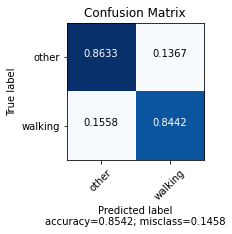

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [ ]:
print('RESULTS FOR GRADIENT BOOSTING:')
print('-------------------')

yhat = XGB.predict(X_test)
print('yhat: ', yhat[0:20])

yhat_prob = XGB.predict_proba(X_test)
print('yhat_prob: ', yhat_prob)
      
print('The mean accuracy of training data is: ', round(XGB.score(X_train,y_train), 2))
print('The mean accuracy of test data is: ', round(XGB.score(X_test,y_test), 2))

print('Jaccard_index test: ', round(jaccard_similarity_score(y_test, yhat), 2))

print('f1_score_test: ', f1_score(y_test, yhat, average=None))
print('f1_score_test_macro: ', round(f1_score(y_test, yhat, average='macro'),2))

fpr, tpr, thresholds = metrics.roc_curve(y_test, yhat)
roc_auc = auc(fpr, tpr)
print('roc_auc_test: ', round(roc_auc,2))

print('-----------------')

cnf_matrix = confusion_matrix(y_test, yhat)
print('cnf_matrix:\n ', cnf_matrix)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, 
                      normalize    = True,
                      target_names = ['other','walking'],
                      title        = "Confusion Matrix")

plt.figure(figsize=(20, 20))


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

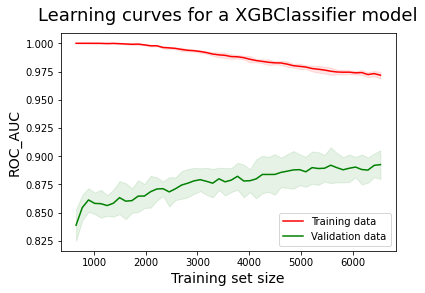

In [ ]:
cv = model_selection.ShuffleSplit(n_splits = 50, test_size = 0.30, random_state = 42)
estimator = XGB_params
plot_learning_curve_auc(estimator, X, y, ylim=(), cv=cv)

In [ ]:
importance

array([0.13, 0.01, 0.06, 0.01, 0.01, 0.04, 0.01, 0.1 , 0.02, 0.04, 0.  ,
       0.03, 0.01, 0.03, 0.01, 0.01, 0.05, 0.05, 0.01, 0.02, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.06, 0.01, 0.01, 0.01, 0.05, 0.09, 0.02,
       0.03, 0.01], dtype=float32)

Feature: 0, Score: 0.13092
Feature: 1, Score: 0.01216
Feature: 2, Score: 0.06214
Feature: 3, Score: 0.01308
Feature: 4, Score: 0.01312
Feature: 5, Score: 0.04189
Feature: 6, Score: 0.00711
Feature: 7, Score: 0.09659
Feature: 8, Score: 0.02038
Feature: 9, Score: 0.03593
Feature: 10, Score: 0.00310
Feature: 11, Score: 0.03289
Feature: 12, Score: 0.00996
Feature: 13, Score: 0.02618
Feature: 14, Score: 0.01176
Feature: 15, Score: 0.01027
Feature: 16, Score: 0.04943
Feature: 17, Score: 0.04961
Feature: 18, Score: 0.00826
Feature: 19, Score: 0.01847
Feature: 20, Score: 0.01071
Feature: 21, Score: 0.01155
Feature: 22, Score: 0.01252
Feature: 23, Score: 0.00883
Feature: 24, Score: 0.01022
Feature: 25, Score: 0.01191
Feature: 26, Score: 0.05740
Feature: 27, Score: 0.01179
Feature: 28, Score: 0.00944
Feature: 29, Score: 0.01085
Feature: 30, Score: 0.04526
Feature: 31, Score: 0.08614
Feature: 32, Score: 0.02186
Feature: 33, Score: 0.02590
Feature: 34, Score: 0.01238


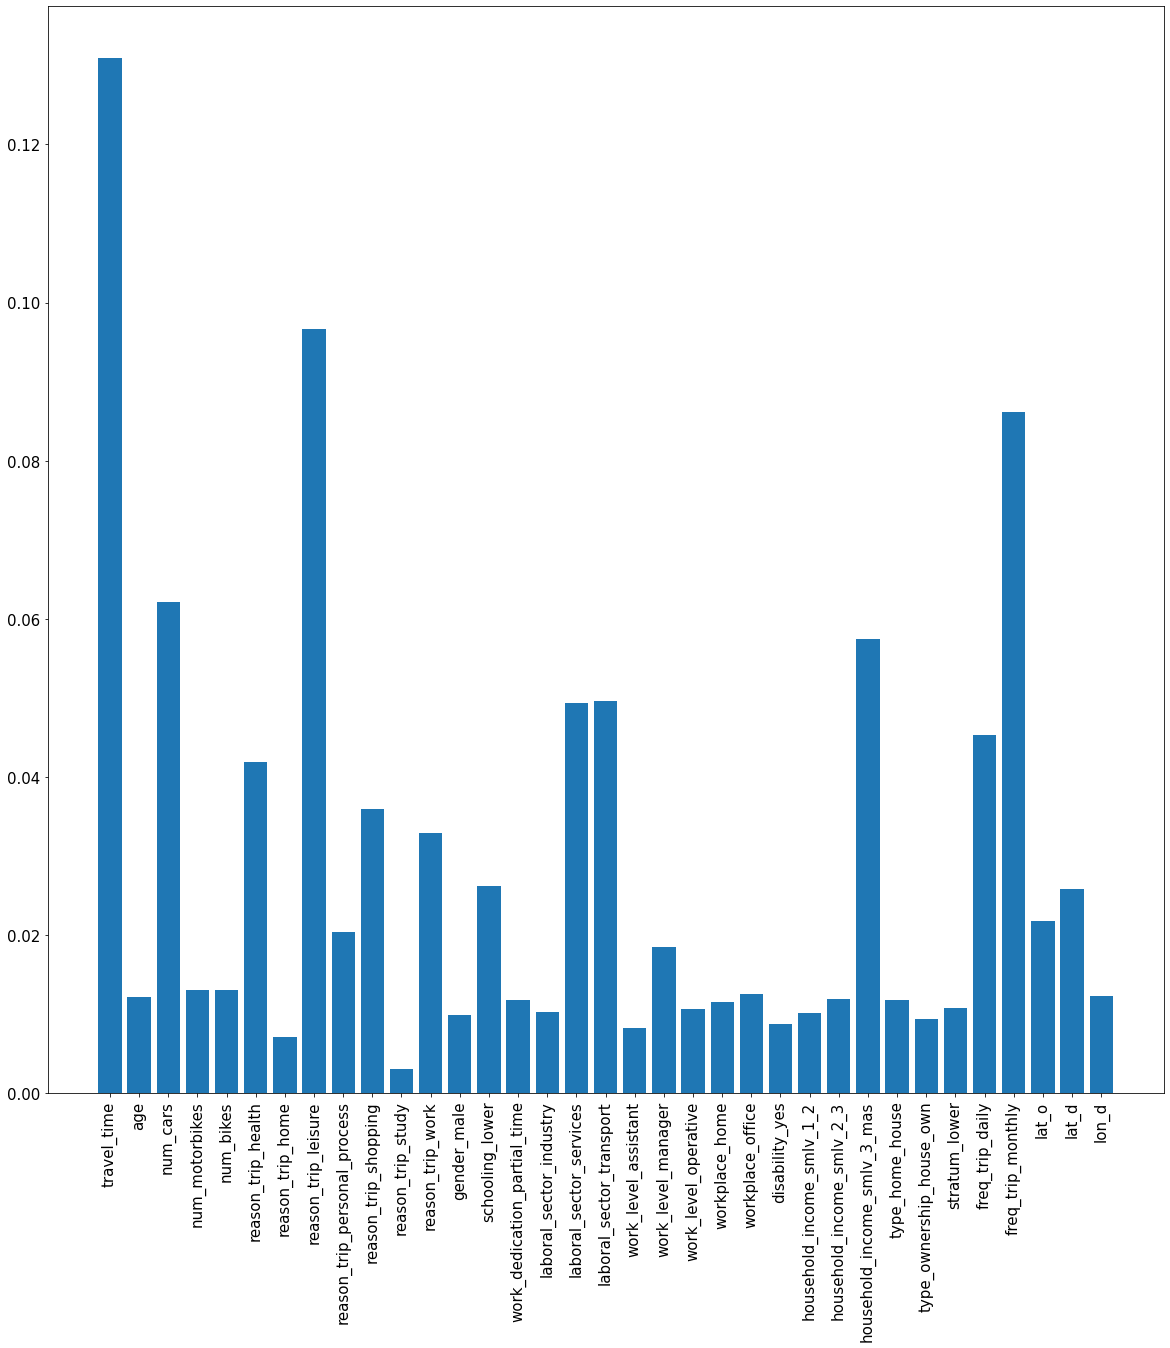

Index(['travel_time', 'age', 'num_cars', 'num_motorbikes', 'num_bikes',
       'reason_trip_health', 'reason_trip_home', 'reason_trip_leisure',
       'reason_trip_personal_process', 'reason_trip_shopping',
       'reason_trip_study', 'reason_trip_work', 'gender_male',
       'schooling_lower', 'work_dedication_partial_time',
       'laboral_sector_industry', 'laboral_sector_services',
       'laboral_sector_transport', 'work_level_assistant',
       'work_level_manager', 'work_level_operative', 'workplace_home',
       'workplace_office', 'disability_yes', 'household_income_smlv_1_2',
       'household_income_smlv_2_3', 'household_income_smlv_3_mas',
       'type_home_house', 'type_ownership_house_own', 'stratum_lower',
       'freq_trip_daily', 'freq_trip_monthly', 'lat_o', 'lat_d', 'lon_d'],
      dtype='object')


In [ ]:
# Feature Importance

importance = XGB_params.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.figure(figsize=(20,20))
pyplot.bar([x for x in range(len(importance))], importance, tick_label=X_columns_final)
pyplot.xticks(rotation=90)
pyplot.tick_params(axis='both', labelsize=15)
pyplot.show()
print(X_columns_final)

In [ ]:
# Analysing for n_estimators, learning_rate and max_depth
n_estimators=[]
max_depth=[]
learning_rate = []
bal_acc = []
for i in tqdm(range(1,101)):
    for j in range(2,10):
        for k in [0.005, 0.01, 0.05, 0.1, 0.5, 1]:
            XGB_params = XGBClassifier(n_estimators=i, max_depth=j, learning_rate=k)
            XGB = XGB_params.fit(X_train,y_train)
            ypred_train = XGB.predict(X_train)
            ypred_test = XGB.predict(X_test)
    
            bal_acc.append(round(balanced_accuracy_score(y_test, ypred_test), 2))
            n_estimators.append(i)
            max_depth.append(j)
            learning_rate.append(k)

100%|██████████| 100/100 [42:47<00:00, 25.67s/it]


In [ ]:
tuning_XGB = pd.DataFrame(list(zip(n_estimators, max_depth, learning_rate, bal_acc)), columns=['n_estimators', 'max_depth', 'learning_rate', 'bal_acc'])
tuning_XGB.sort_values(by=['bal_acc'], inplace=True, ascending=False)

tuning_XGB.to_csv(base_dir + 'tuning_XGB.csv')
tuning_XGB.head(10)

,n_estimators,max_depth,learning_rate,bal_acc
4444,93,6,0.5,0.87
3916,82,6,0.5,0.87
4732,99,6,0.5,0.87
4781,100,6,1.0,0.87
4780,100,6,0.5,0.87
3580,75,6,0.5,0.87
3934,82,9,0.5,0.87
4156,87,6,0.5,0.87
4642,97,7,0.5,0.87
4348,91,6,0.5,0.87


In [ ]:
tuning_XGB = pd.read_csv(base_dir + 'tuning_XGB.csv').iloc[:,1:]
print('Shape of tuning_XGB:', tuning_XGB.shape)
tuning_XGB.head()

Shape of tuning_XGB: (4800, 4)


,n_estimators,max_depth,learning_rate,bal_acc
0,93,6,0.5,0.87
1,82,6,0.5,0.87
2,99,6,0.5,0.87
3,100,6,1.0,0.87
4,100,6,0.5,0.87


# 7. SHAP values

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


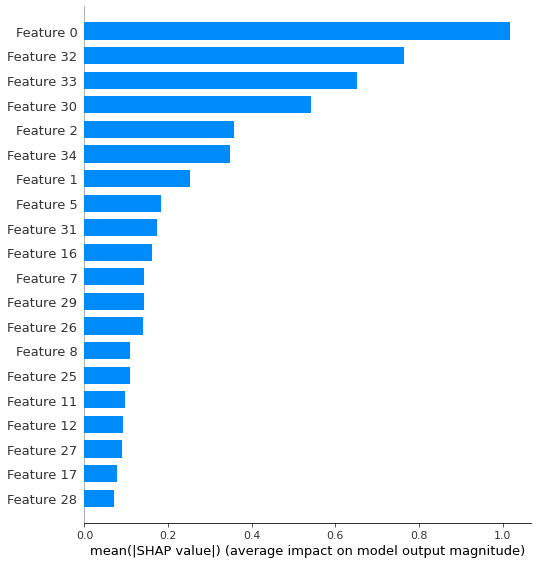

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [ ]:
explainer = shap.TreeExplainer(XGB_params)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [ ]:
shap_values

array([[ 1.44, -1.38,  0.19, ...,  0.31,  0.48, -0.29],
       [ 0.83, -0.1 , -1.73, ..., -0.46,  0.42,  0.45],
       [-0.9 ,  0.02,  0.22, ...,  0.33, -0.95, -0.28],
       ...,
       [-1.48,  0.44,  0.2 , ..., -0.14, -1.98, -0.46],
       [ 2.61,  0.19,  0.18, ..., -0.27,  0.47,  0.48],
       [ 0.6 ,  0.63,  0.18, ...,  1.14, -0.45, -0.38]], dtype=float32)

In [ ]:
features_labels = ['type_ownership_house_own', 'laboral_sector_transport', 'type_home_house', 'gender_male', 'reason_trip_work', 'household_income_smlv_2_3', 'reason_trip_personal_process', 
 'household_income_high', 'stratum_lower', 'reason_trip_leisure', 'laboral_sector_services', 'freq_trip_monthly', 'reason_trip_health', 'age', 'lon_d',
 'num_cars', 'freq_trip_daily', 'lat_d', 'lat_o', 'travel_time']

No handles with labels found to put in legend.


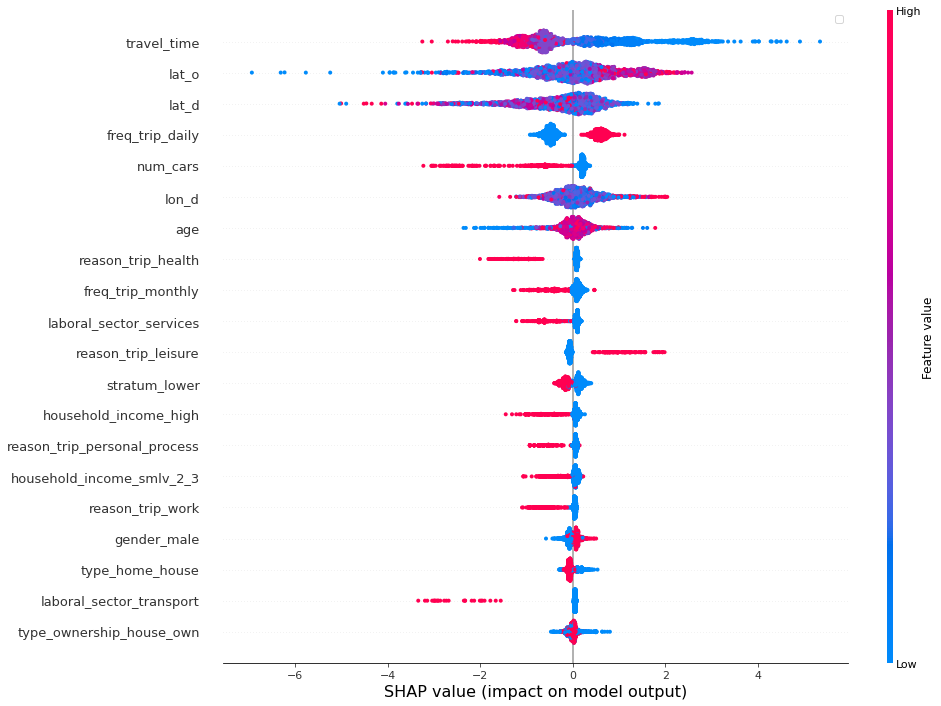

In [ ]:
shap.summary_plot(shap_values,X_test, color=plt.get_cmap("tab10"), show=False)
fig = plt.gcf()
fig.set_figheight(12)
fig.set_figwidth(14)
ax = plt.gca()
ax.set_xlabel('SHAP value (impact on model output)', fontsize=16)
ax.set_yticklabels(features_labels)
leg = ax.legend()
for l in leg.get_texts(): l.set_text(l.get_text().replace('Class', 'Klasse'))
plt.show()

* Feature importance: Variables are ranked in descending order.
* Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
* Original value: Color shows whether that choice is walking (in red) or other mode (in blue) for that observation.
* Correlation: A high travel_time has a high and positive impact on the 'other modes' choice. The 'other modes' comes from the blue color, and the “positive” impact is shown on the X-axis. Similarly, we will say the 'number of cars' is negatively correlated with the 'other mode', bu positively correlated with the 'walking mode'.

No handles with labels found to put in legend.


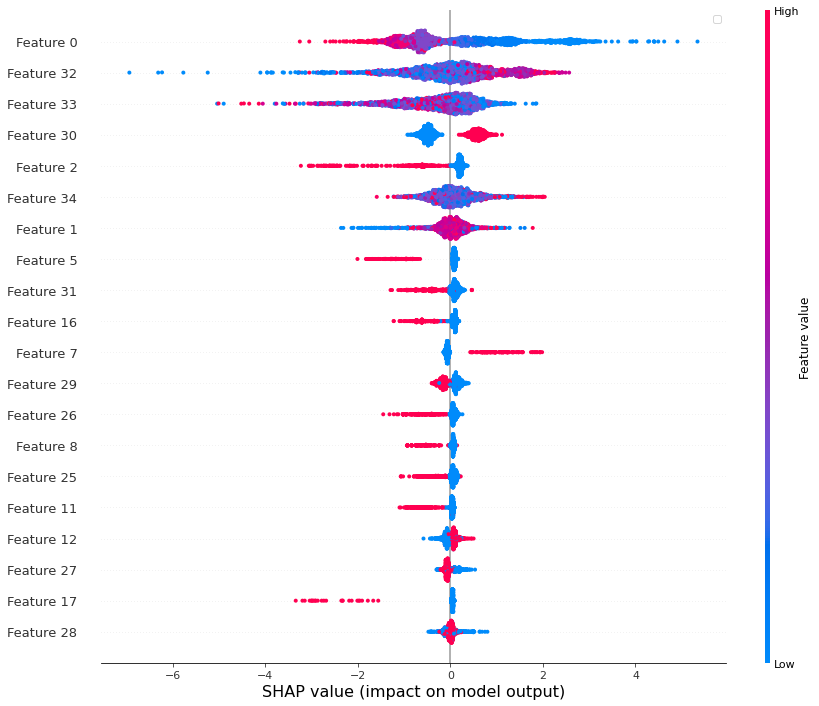

In [ ]:
# This is the same figure used to verify the feature labels
shap.summary_plot(shap_values,X_test, color=plt.get_cmap("tab10"), show=False)
fig = plt.gcf()
fig.set_figheight(12)
fig.set_figwidth(14)
ax = plt.gca()
ax.set_xlabel('SHAP value (impact on model output)', fontsize=16)
#ax.set_yticklabels(features_order)
leg = ax.legend()
for l in leg.get_texts(): l.set_text(l.get_text().replace('Class', 'Klasse'))
plt.show()

In [ ]:
# Feature labels
[0 'travel_time',
 1 'age',
 2 'num_cars',
 3 'num_motorbikes',
 4 'num_bikes'
 5 'reason_trip_health',
 6'reason_trip_home',
 7'reason_trip_leisure',
 8'reason_trip_personal_process',
 9'reason_trip_shopping',
 10'reason_trip_study', 
 11'reason_trip_work', 
 12'gender_male',
 13'schooling_lower', 
 14'work_dedication_partial_time',
 15'laboral_sector_industry', 
 16'laboral_sector_services',
 17'laboral_sector_transport', 
 18'work_level_assistant',
 19'work_level_manager', 
 20'work_level_operative', 
 21'workplace_home',
 22'workplace_office', 
 23'disability_yes', 
 24'household_income_smlv_1_2',
 25'household_income_smlv_2_3',
 26'household_income_smlv_3_mas',
 27'type_home_house', 
 28'type_ownership_house_own', 
 29'stratum_lower',
 30'freq_trip_daily', 
 31'freq_trip_monthly', 
 32'lat_o', 
 33'lat_d', 
 34'lon_d']